### 1. 引入套件

In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### 2. 下載^VIX和^GSPC資料
時間區間為2010-01-01至2024-12-31

In [33]:

start_date = '2010-01-01'
end_date = '2024-12-31'

vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)
gspc = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

### 3. 資料預處理

3.1 建立^VIX每月第一個交易日的Adj Close*0.01，index改為年-月

In [34]:
vix_monthly = vix['Adj Close'].resample('MS').first() * 0.01
vix_monthly.index = vix_monthly.index.to_period('M')

vix_monthly

3.2 建立^VIX每月第一個交易日的Adj Close*0.01，index改為年-月

In [36]:
gspc['Monthly_Return'] = gspc['Adj Close'].pct_change()
gspc_volatility = gspc['Monthly_Return'].resample('M').std() * np.sqrt(12)
gspc_volatility = gspc_volatility.to_frame(name='Annualized_Volatility')
gspc_volatility.index = gspc_volatility.index.to_period('M')

gspc_volatility

<ipython-input-36-9b2543b34e1c>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gspc_volatility = gspc['Monthly_Return'].resample('M').std() * np.sqrt(12)


,Annualized_Volatility
Date,
2010-01,0.033395
2010-02,0.039396
2010-03,0.016347
2010-04,0.032702
2010-05,0.070074
...,...
2024-08,0.042478
2024-09,0.030202
2024-10,0.024028


3.3 合併兩個dataframe

In [43]:
data = pd.concat([vix_monthly, gspc_volatility], axis=1)
data.columns = ['VIX_Adj_Close', 'GSPC_Std_Adj_Close']
data.dropna(inplace=True)

data

,VIX_Adj_Close,GSPC_Std_Adj_Close
Date,,
2010-01,0.2004,0.033395
2010-02,0.2259,0.039396
2010-03,0.1926,0.016347
2010-04,0.1747,0.032702
2010-05,0.2019,0.070074
...,...,...
2024-08,0.1859,0.042478
2024-09,0.2072,0.030202
2024-10,0.1926,0.024028


### 4. LSTM模型訓練

4.1 分割訓練資料與測試資料

In [38]:
train_data = data.loc['2010-01':'2023-12']
test_data = data.loc['2024-01':'2024-12']

4.2 轉換格式、模型訓練與測試資料預測

In [39]:
# 進行特徵縮放
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# 轉換成LSTM的格式
X_train = scaled_train[:, 0].reshape(-1, 1, 1)  # VIX_Adj_Close as input
y_train = scaled_train[:, 1]  # GSPC_Std_Adj_Close as output
X_test = scaled_test[:, 0].reshape(-1, 1, 1)
y_test = scaled_test[:, 1]

# 建立LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 預測資料
predictions = model.predict(X_test)

# 反向縮放預測與實際資料
predictions_rescaled = scaler.inverse_transform(np.concatenate((scaled_test[:, 0].reshape(-1, 1), predictions), axis=1))[:, 1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((scaled_test[:, 0].reshape(-1, 1), y_test.reshape(-1, 1)), axis=1))[:, 1]

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


In [40]:
predictions_rescaled

array([0.02711161, 0.02778425, 0.02702267, 0.0275566 , 0.029282  ,
       0.02702267, 0.02614427, 0.03247439, 0.03461273, 0.03314588,
       0.03578164, 0.02725   ])

In [41]:
y_test_rescaled

array([0.02408632, 0.02665063, 0.02153084, 0.02906696, 0.02038095,
       0.0140027 , 0.03154307, 0.04247801, 0.03020198, 0.02402783,
       0.02642055, 0.03183579])

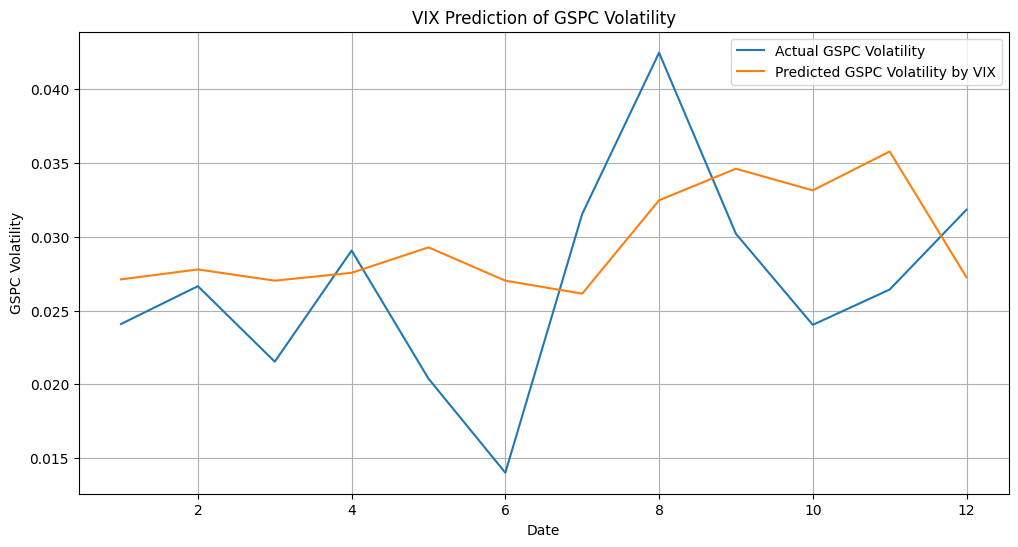

In [42]:
# 繪製實際資料與預測資料
plt.figure(figsize=(12, 6))
plt.plot(list(range(1, 13)), y_test_rescaled, label='Actual GSPC Volatility')
plt.plot(list(range(1, 13)), predictions_rescaled, label='Predicted GSPC Volatility by VIX')
plt.xlabel('Date')
plt.ylabel('GSPC Volatility')
plt.title('VIX Prediction of GSPC Volatility')
plt.legend()
plt.grid()
plt.show()